In [2]:
import numpy as np
import scipy.linalg as la
import math
import scipy.stats as sps
from scipy.stats import uniform_direction
from math import atan, log, pi
from datetime import datetime as dt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score
from scipy.optimize import minimize

In [19]:
dataset = "mushrooms.txt"
data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
n, m = X.shape
y = y * 2 - 3
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

(8124, 112) (8124,)


In [4]:
def grad_function_log(w, X_train, y_train, lambda_):
    X = X_train
    Y = y_train
    sum = np.zeros(w.shape)
    n = X.shape[0]

    for i in range(len(Y)):
        sum = sum  - 1/n * Y[i] * X[i] /(1 + np.exp(-Y[i] * w @ X[i])) * np.exp(-Y[i] * w @ X[i])
    return sum + lambda_ * w

def hessian_function_log(w, X_train, y_train, lambda_):
    X = X_train
    Y = y_train
    n = X.shape[0]
    sum = np.zeros((X.shape[1], X.shape[1]))

    for i in range(1, len(Y)):
        sum = sum + 1/n * np.outer(X[i], X[i]) * np.exp(Y[i] * w @ X[i])/((1+np.exp(Y[i] * w @ X[i])) ** 2)
    return sum + lambda_* np.eye(X.shape[1])

def learning_rate_log(x, L):
    return 1 / L

def predict(w, X):
        return np.sign(X @ w)

In [5]:
def get_r_k(xi, hess_diffs_norm, grad_norm, L_hess, L_rho, eta, sigma):
    b = hess_diffs_norm / np.sqrt(grad_norm) + L_rho * hess_diffs_norm / (2 * (2 * sigma - L_rho))
    a = L_hess / 3 + L_rho * (2 * eta + L_hess / 3) / (2 * sigma - L_rho)
    return xi / (b + np.sqrt(a * xi))

def get_A_k (r_k, L_hess, L_rho, hess_diffs_norm, grad_norm, eta, sigma):
    tilde_sigma = 2 * sigma - L_rho
    A_k = hess_diffs_norm / (2 * tilde_sigma) + r_k * np.sqrt(grad_norm) * (2 * eta + L_hess / 3) / tilde_sigma
    return A_k

In [6]:
def objective(d, grad_f, H_k, A_k):
    grad_term = np.dot(grad_f, d)
    hess_term = 0.5 * np.dot(d.T, np.dot(H_k, d))
    # Regularization term: A_k * V(x_k, x_k + d) = A_k * 1/2 * ||d||^2
    reg_term = 0.5 * A_k * np.linalg.norm(d)**2
    return grad_term + hess_term + reg_term

In [7]:
def constraint(d, grad_f, r_k):
    return r_k**2 * np.linalg.norm(grad_f) - np.linalg.norm(d)**2

In [8]:
def empirical_fisher_approximation(X_train, y_train, w):
        N = len(y_train)
        fisher_matrix = np.zeros((len(w), len(w))) 

        for i in range(N):
            xi = X_train[i]
            yi = y_train[i]
            f_xi = np.sign(np.dot(xi, w))  
            grad_loss = (f_xi - yi) * xi 
            fisher_matrix += np.outer(grad_loss, grad_loss)
        
        return fisher_matrix / N

training, mushrooms

In [34]:
def compute_lipsch(X_train, y_train):
    n, m = X_train.shape
    hessian = np.zeros((m, m))

    for a, b in zip(X_train[:], y_train):
        hessian = hessian + 1/n  * np.outer(a, a)

    hessian = hessian / 4
    L = np.linalg.norm(hessian, 2)
    print('L for the hess', L)
    lambda_ = L / 100
    return L, lambda_

L, lambda_ = compute_lipsch(X_train, y_train)

L for the hess 626758.4521372562


In [12]:
L_hess = L
L_rho = 2.
eta = 1.5
sigma = 1.666666666666665#(L_rho / 2 + 2 * L_rho / 3) / 2 
xi = 1 / 2 #1 / 2
accuracy_arr = []
hess_diffs_norms = []
grad_norms = []
x_k = np.zeros(X_train.shape[1])
accuracy = []

num_iters = 50
for iter_idx in range(num_iters):
    grad_f = grad_function_log(x_k, X_train, y_train, lambda_)
    grad_f_norm = np.linalg.norm(grad_f, ord=2)
    grad_norms.append(grad_f_norm)

    H_true = hessian_function_log(x_k, X_train, y_train, lambda_)
    H_k = empirical_fisher_approximation(X_train, y_train, x_k)
    hess_diff_norm = np.linalg.norm(H_true - H_k, ord=2)
    hess_diffs_norms.append(hess_diff_norm)

    r_k = get_r_k(xi, hess_diff_norm, grad_f_norm, L_hess, L_rho, eta, sigma)
    A_k = get_A_k(r_k, L_hess, L_rho, hess_diff_norm, grad_f_norm, eta, sigma)

    d0 = np.zeros_like(grad_f)

    cons = {'type': 'ineq', 'fun': constraint, 'args': (grad_f, r_k)}

    result = minimize(objective, d0, args=(grad_f, H_k, A_k), constraints=cons, method='SLSQP')

    d_k = result.x

    x_k += d_k
    accuracy.append(accuracy_score(predict(x_k, X_test), y_test))
    print(np.linalg.norm(x_k))

0.02115404949685723
0.062282074702698524
0.1017517388545027
0.14006184133981378
0.1773366687897734
0.21356013351330694
0.24868131068764096
0.2828310382234962
0.31599869774228256
0.3482214305063966
0.3795197499754849
0.40995844765480816
0.439603248145791
0.46848953615059447
0.4966085461747668
0.5240154330546882
0.5507186157773287
0.5769104223917342
0.6025079140960138
0.6274725543054025
0.6518642100716251
0.6756245151797635
0.6989155080993922
0.7216798282183486
0.7439783634067662
0.7658161465319171
0.7871417594314922
0.8080372040023989
0.8285577136040285
0.8485976787303754
0.8682804364799199
0.887625241160738
0.9065771903229213
0.925177568996357
0.9434674327627958
0.9614901646975533
0.9791715474399871
0.9965413024056704
1.0136102390789092
1.0303270747161857
1.0468238171364153
1.0630759426743503
1.0791216562811337
1.0950229981414958
1.1106134216061523
1.1259044594170746
1.1410153869986424
1.155843243264805
1.1705541258558
1.185018770901116


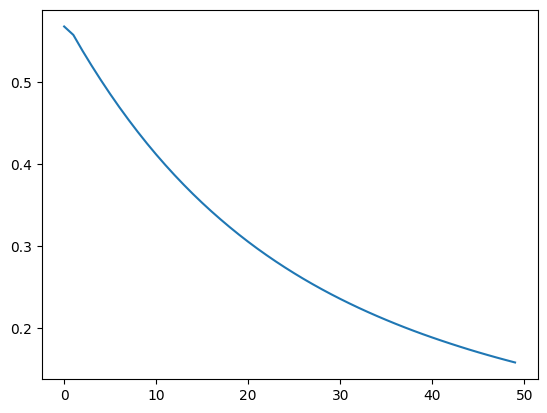

In [13]:
plt.plot(grad_norms)
plt.show()